# Text


The special thing about text: The input is always text.
At least for the cases that will be presented here.

The output, however, can differ. Ranging from:

- Scores
  - Classification
  - Sentiment Analysis
- Text
  - Translations
  - Text generation (aka Language Modeling
  - Summarization
  - (Extractive) Question Answering
  

References:

- BERT meets Shapley: https://aclanthology.org/2021.hackashop-1.3.pdf
- 

In this chapter we will primarily work with transformers which are state-of-the-art for text ML."

## How SHAP for text works

As usual for SHAP, the goal is to attribute the prediction to the inputs.

So SHAP is defined for scalar outputs.

The inputs for text models are, well, texts. The features however can be the individual words, the tokens which depends on a choice of tokenizer or even the individual characters.


What the prediction is depends on the task. The simplest case: A probability score as in sentiment analysis.

The output for "I returned the item as it didn't work." could be negative with score of 0.8.

Then we attribute the scores to the inputs, which, let's say is based on the words ["I", "returned", "the", "item", "as", "it", "didn't", "work"].

This is our team and we want to fairly attribute the 0.8 among these teamm members.

This means the input text is modified by removing team members and computing their marginal contributions.

Again the question arises: how are features (here words) simualted as absent.

Again, this can technically be answered by using masks.


When it's seq2seq then the output is a sequence of tokens.
But again: ShAp needs a scalar output.
So instead, we only look at a token at a time and also not at the token itself, but at its logits.



## Classification

Let's start with the simplest example of a classification task. Because we have already done classification, only this time we have text as input.

A classic example is sentiment analysis, which has gotten it's own name for a task, but in fact is just plain classification with pre-determined labels. (positive, negative).

We will use transformers from Hugging Face which make it super easy to implement it:

In [1]:
from transformers import pipeline

sentiment = pipeline("sentiment-analysis", return_all_scores=True)

s = ["IBM Watson was a scam"]
print(sentiment(s))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[[{'label': 'NEGATIVE', 'score': 0.9995707869529724}, {'label': 'POSITIVE', 'score': 0.00042914910591207445}]]


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Rightfully, this is classified as a negative statement. But why? At humans we know why. One keyword here is "scam".

Let's see if that was also the reason for the model and whether SHAP can handle the situation.

We can simply produce an explainer model. Shap automatically knows how to handle the situation:

In [2]:
import shap
explainer = shap.Explainer(sentiment)

In [3]:
shap_values = explainer(s)

In [4]:
shap.plots.text(shap_values[:,:,"NEGATIVE"])

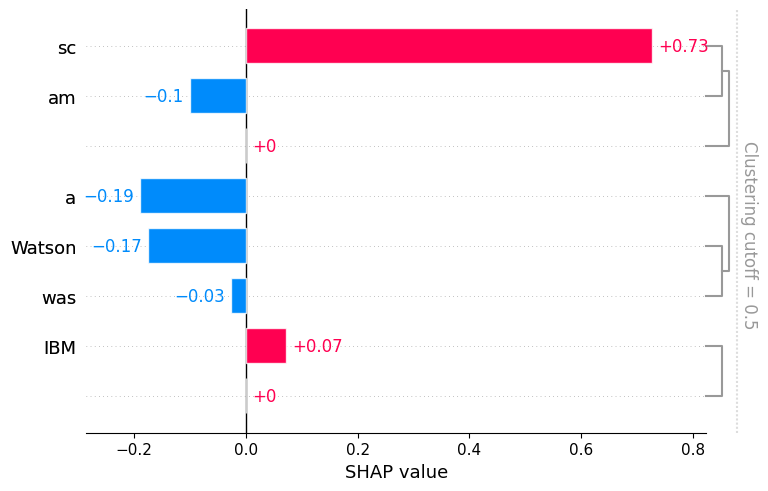

In [5]:
shap.plots.bar(shap_values[0,:, "NEGATIVE"])

We see that "IBM" and "sc" contributed the most to negative sentiment, especaailly "sc".

Weird thing: Scam is cut into "sc" and "am", which I don't like at all. But that's a question of how we mask the input. Masking in the case of text is determined by which tokenizer we use.

So let's play around with this option:

But first we "fix" another problem: Output is on the probability space between 0 and 1, which had to undergo a logit transformation.
Additive explanations, however, work better on linear scales. In this case the logits, which are just before this 0 to 1 squeezing.

shap implements, especially for transformers a wrapper that can be used. Here we have the option to say whether we want the logits or the probabilities:

In [6]:
model = shap.models.TransformersPipeline(sentiment, rescale_to_logits=True)


Just like with the original transformer, we can make predictions with this model:

In [7]:
model(s)

array([[ 7.75312784, -7.75327689]])

Let's see how it affects the explanations with shap:

In [8]:
explainer2 = shap.Explainer(model)
shap_values2 = explainer2(s)
shap.plots.text(shap_values2[:,:,0])

Kinda the same, which is good, but with "am" also being a positive factor, which makes more sense now

In [9]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(s)
shap.plots.text(shap_values[:,:,"NEGATIVE"])

So here it becomes more clear that "scam" is the word of interest.

The tokenizer is totally flexible.

Here is an example based on sentences. Here the tokenizer is super dumb and just tokenizes the input at the dots ".". Let's try a longer input text and see how much each sentence contributes.

In [10]:
many_sentences = ["IBM was a scam. It was more about marketing than technology. But that's why I loved it. Learned a bunch about marketing that way."]
print(sentiment(many_sentences))
masker = shap.maskers.Text(tokenizer=r"\.", mask_token=" ")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(many_sentences)
shap.plots.text(shap_values[:,:,"POSITIVE"])

[[{'label': 'NEGATIVE', 'score': 0.0005120987189002335}, {'label': 'POSITIVE', 'score': 0.9994878768920898}]]


As a mask token we used a whitespace " ", which seems okay for dropping a sentence. The default for this case is "...", but in general if a tokenizer is supplied the .mask_token attribute is used, if the tokenizer has this attribute.

The tokenizer acts as a background dataset.

I want to demonstrate this by doing some "extreme" masking: Instead of removing a sentence and replacing it with nothing, we replace it with a particular sentence.

By the way, the argument , collapse_mask_token=True makes that if two tokens in a row are replaced by the mask_token that the token is only added once.

So if, in the next example the sentences are replaced with "I love it", then only once in a row.

Input: IBM was a scam.
It was more about marketing than technology.
But that's why I loved it.
Learned a bunch about marketing that way

Let's say for the marginal contribution of "Learned a bunch about marketing", when added to the empty set, we actually compare the prediction for these two sentences:

"I love it. Learned a bunch about marketing that way." versus "I love it."

If collapse_mask_token=False, then we would compare predictions for "I love it. I love it. I love it. Learned a bunch about marketing that way." versus "I love it. I love it. I love it. I love it."

So it often makes sense to set collapse_mask_token to True.

In theory you could also write a custom masker.



In [11]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token="I love it", collapse_mask_token=True)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(many_sentences)
shap.plots.text(shap_values[:,:,"POSITIVE"])

In [12]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token="I hate it", collapse_mask_token=True)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(many_sentences)
shap.plots.text(shap_values[:,:,"POSITIVE"])

What happens here?
The replacement is acting as a reference. In one case any sentence that is dropped from the coalition is replaced with "I love it" and for the other explanation with "I hate it".

What changes?

The base value changes from strongly positive to negative. Every sentence is now to be interpreted in contrast with the replacement. This was also true before, but before we replaced it with an empty string which is more neutral than the sentences provided.

Don't use such extreme masking tokens, this obviously don't make sense. But it can make sense to use more specific tokens.

And the lesson here is that the masking does matter, because it serves as the background data. So you should be aware of the replacement and think about whether it makes sense. Maybe test out alternatives.

For example, there's even a difference whether we replace tokens with " " or "...":

In [13]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token="...", collapse_mask_token=True)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(many_sentences)
shap.plots.text(shap_values[:,:,"POSITIVE"])

In [14]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token=" ", collapse_mask_token=True)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(many_sentences)
shap.plots.text(shap_values[:,:,"POSITIVE"])

While the overall attribution doesn't change in a relevant way (except for sign change for the "marketing" sentence, but which was close to zero anyways), it does change the base value by quite a bit.

So, play around with it, maybe generate some text with it and make a qualitative judgement on whether it makes sense or not.

## How text to text works with SHAP

- We got a bit of a problem with text to text
- because the outcome is text
- let's say it's translation or text generation
- text is "this is a banana"
- what's there to attribute?
- all examples before had some kind of numerical score
- in regression it's directly the model output
- for classification, you can use the scores
- but for text it needs an intermediate step
- Trick 1: We create an explanation for each output token
- Trick 2: For each token, we first decode it and attribute the log odds of that token.
- Luckily most of it is already done by the shap package
- 

## Text Generation

For text generatio, we will look at transformer models.

You know, the type of model powering ChatGPT and GPT-3. But since we want an example that runs without requiring an account somewhere, we do this locally and use a "weaker" model.

In theory, however, it would be possible to do this via API as well. Because Shapley values are model-agnostic.


So for this example, we use GPT-2. That's what's automatically chosen, at the time of writing, from the transformers library for the task "text-generation"

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

In [16]:
input_text = "He insulted Italian cuisine by"

# Encode input text
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate text with stop_token set to "."
output = model.generate(
    input_ids,
    max_length=30,
    do_sample=True,
    num_return_sequences=5
)

# Decode output text
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


He insulted Italian cuisine by wearing a tuxedo with the words "Mittel" (MittEL) or "Marco," a combination of


In [19]:
# setting model to decoder is necessary so that the input isn't repeated.
model.config.is_decoder=True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 30,
    "top_k": 50,
    "no_repeat_ngram_size": 2
}
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer([input_text])
shap.plots.text(shap_values)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


In [20]:
shap.plots.bar(shap_values)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

We have two problems:

- The input is repeated, and we don't care about it
- some words are ripped into two


## Translation

Translation is another text to text task.

So again, in this case we will get for each output word an explanation.

Auto classes in hugging face: Automatically derive the relevant model for some task.
But can also be used to retrieve a model from Hugging face based on username and model-name.

In [117]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import shap
import torch



In [120]:
# load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")


OSError: translation_en_to_de is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

CONTINUE HERE

Figure out how to make translation work. Maybe be closer to the tutorial on shap documentation

In [121]:
from transformers import pipeline

translator = pipeline("translation_en_to_de")
s = "German humor is no laughing matter."
print(translator(s))

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future versio

[{'translation_text': 'Der deutsche Humor ist kein Lachen.'}]


In [156]:
explainer = shap.Explainer(translator.model, translator.tokenizer)

In [157]:
shap_values = explainer([s])

Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 300 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


In [137]:
translator.tokenizer.encode?

In [139]:
translator.model(translator.tokenizer.encode(s, return_tensors='pt'))

ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

In [132]:
shap.plots.text(shap_values)

## Summary

In [31]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(translator, masker=translator.tokenizer)
shap_values = explainer(s)
shap.plots.text(shap_values)

Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 300 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
Partition explainer:  20%|█████████████████████▊                                                                                       | 7/35 [00:41<03:52,  8.31s/it]


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:


import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import shap
import torch



# load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es").cuda()

# define the input sentences we want to translate
data = [
    "Transformers have rapidly become the model of choice for NLP problems, replacing older recurrent neural network models"
]

# the tokenizer we want to use to break up the input strings
explainer = shap.Explainer(model, tokenizer)

# explainers are callable, just like models
shap_values = explainer(data, fixed_context=1)

shap.plots.text(shap_values)